# Trained Model with Merged Bureau Data:

In [2]:
import pandas as pd
import sys
sys.path.append('/Users/belleshen/Documents/VS_Code/Project/belle_functions/')
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, accuracy_score, plot_roc_curve
from belle_library import _missing_values_cols, train_test_combined, _fill_na, _find_delete_cols, _remove_cols, create_dummies, dummy_maintable_merge

In [1]:
def feature_engineering(df, new_col, col_lst):

    df[new_col] = df[col_lst[0]].combine(df[col_lst[1]], lambda x, y: x/y if y != 0 else 0)
    df.drop(col_lst, axis = 1, inplace = True)
    return df

In [3]:
df           = pd.read_csv('/Users/belleshen/Documents/VS_Code/LFZ/Assignment/solution/W6/tran_bureau_merged.csv')

cat_cols     = [
                'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'CREDIT_ACTIVE', 'CREDIT_TYPE', 'OCCUPATION_TYPE'
               ]
nu_cols      = [
                'SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CREDIT_DAY_OVERDUE', 
                'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE'
               ] 
ordinal_cols = [
                'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY'
               ]

main_cols    = nu_cols+ cat_cols + ordinal_cols 
main_table   = df[main_cols]

# drop over 50% missing values columns:

many_null_cols = _missing_values_cols(main_table)
main_table.drop(many_null_cols, axis = 1, inplace=True)

# define x & y:

x = main_table
y = df[['TARGET']]

# splitting data into train & test:

train_combined, test_combined = train_test_combined(x, y, .2, 42, y)

# missing values handling:

cols_agg      = {
                 'AMT_GOODS_PRICE'       : train_combined.AMT_GOODS_PRICE.mean(),
                 'OCCUPATION_TYPE'       : 'missing_values',
                 'EXT_SOURCE_2'          : train_combined.EXT_SOURCE_2.mean(),
                 'EXT_SOURCE_3'          : train_combined.EXT_SOURCE_3.mean(),
                 'CREDIT_ACTIVE'         : 'missing_values',
                 'CREDIT_DAY_OVERDUE'    : train_combined['CREDIT_DAY_OVERDUE'].median(),
                 'CNT_CREDIT_PROLONG'    : train_combined['CNT_CREDIT_PROLONG'].median(),
                 'AMT_CREDIT_SUM'        : train_combined['AMT_CREDIT_SUM'].median(),
                 'AMT_CREDIT_SUM_OVERDUE': train_combined['AMT_CREDIT_SUM_OVERDUE'].median(),
                 'CREDIT_TYPE'           : 'missing_values',
                 'AMT_CREDIT_MAX_OVERDUE': train_combined['AMT_CREDIT_MAX_OVERDUE'].median(),
                 'AMT_CREDIT_SUM_DEBT'   : train_combined['AMT_CREDIT_SUM_DEBT'].median(),
                 'AMT_CREDIT_SUM_LIMIT'  : train_combined['AMT_CREDIT_SUM_LIMIT'].median()
                }

_fill_na(train_combined, cols_agg)
_fill_na(test_combined, cols_agg)

# find deleted categorical cols:
 
deleted_cols                   = _find_delete_cols(nu_cols, many_null_cols)

# define new cat_cols:

new_nu_cols                   = _remove_cols(deleted_cols, nu_cols)

# one hot encoding:

train_dummies, test_dummies    = create_dummies(train_combined, test_combined, cat_cols)

# merge dummies back to the main table:

train_combined_1               = dummy_maintable_merge(train_combined, train_dummies, cat_cols)
test_combined_1                = dummy_maintable_merge(test_combined, test_dummies, cat_cols)

# feature engineering:

train_combined_1               = feature_engineering(train_combined_1, 'AMT_CREDIT_RATIO', ['AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT'])
test_combined_1                = feature_engineering(test_combined_1, 'AMT_CREDIT_RATIO', ['AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT'])

# define x & y for model training:

x_train_1 = train_combined_1.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
y_train_1 = train_combined_1[['TARGET']]
x_test_1 = test_combined_1.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
y_test_1 = test_combined_1[['TARGET']]

# modeling:

model = xgb.XGBRFClassifier(random_state = 42, scale_pos_weight = 282686/24825)
model.fit(x_train_1, y_train_1)
pred = model.predict(x_test_1)


/Users/belleshen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/belleshen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/belleshen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[11:14:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# check the metrics (evaluation of the model):

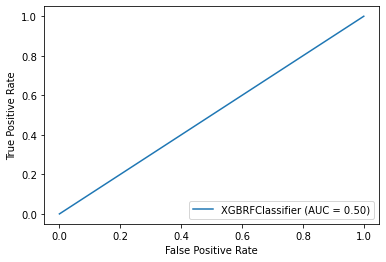

In [4]:
plot_roc_curve(model, y_test_1, pred)

In [5]:
recall_score(y_test_1, pred), precision_score(y_test_1, pred)

(0.6467270896273918, 0.15240400588542408)

# Data prep for the test data:

In [6]:
test = pd.read_csv('/Users/belleshen/Documents/VS_Code/Project/HomeCreditDefault/data/test_bureau.csv')
main_table_test          = test[main_cols]
main_table_test.drop(many_null_cols, axis = 1, inplace=True)
_fill_na(main_table_test, cols_agg)
deleted_cols_test        = _find_delete_cols(nu_cols, many_null_cols)
new_nu_cols_test         = _remove_cols(deleted_cols_test, nu_cols)

test_dummies             = pd.get_dummies(main_table_test[cat_cols])
test_dummies             = test_dummies.reindex(columns = train_dummies.columns, fill_value = 0)
test_dummies             = test_dummies[train_dummies.columns]

main_table_test_1        = dummy_maintable_merge(main_table_test, test_dummies, cat_cols)
main_table_test_1        = feature_engineering(main_table_test_1, 'AMT_CREDIT_RATIO', ['AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT'])

main_table_test_1.drop(['SK_ID_CURR'], axis = 1, inplace = True)
pred_submission          = model.predict(main_table_test_1)

/Users/belleshen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/belleshen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


# Plotting Feature Importance:

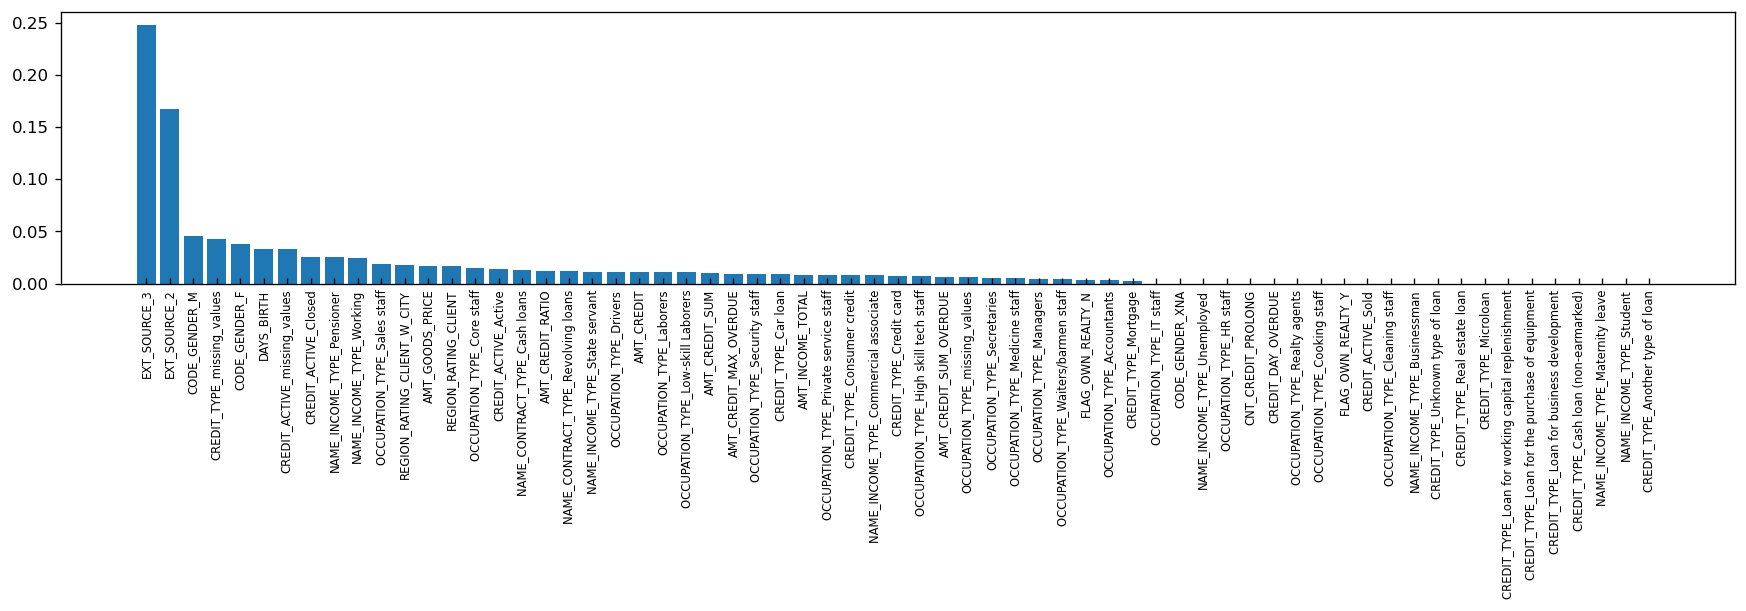

In [7]:
feature_importance = pd.DataFrame(model.feature_importances_, columns = ['feature_importance'])
col_names = pd.DataFrame(x_train_1.columns, columns = ['features'])
feature_importance_df = col_names.merge(feature_importance, how = 'left', left_index = True, right_index = True)
feature_importance_df.sort_values(by = 'feature_importance', ascending = False, inplace = True)

# plotting:
fig, ax = plt.subplots(figsize = (18, 3), dpi = 120)

ax.bar(feature_importance_df['features'], feature_importance_df['feature_importance'])
ax.tick_params(axis = 'x', direction = 'in', rotation = 90, labelsize = 'x-small');


# Plot top 15 features with dropping those 'missing_values' class and then here is the top 13 bar chart of feauture importance:

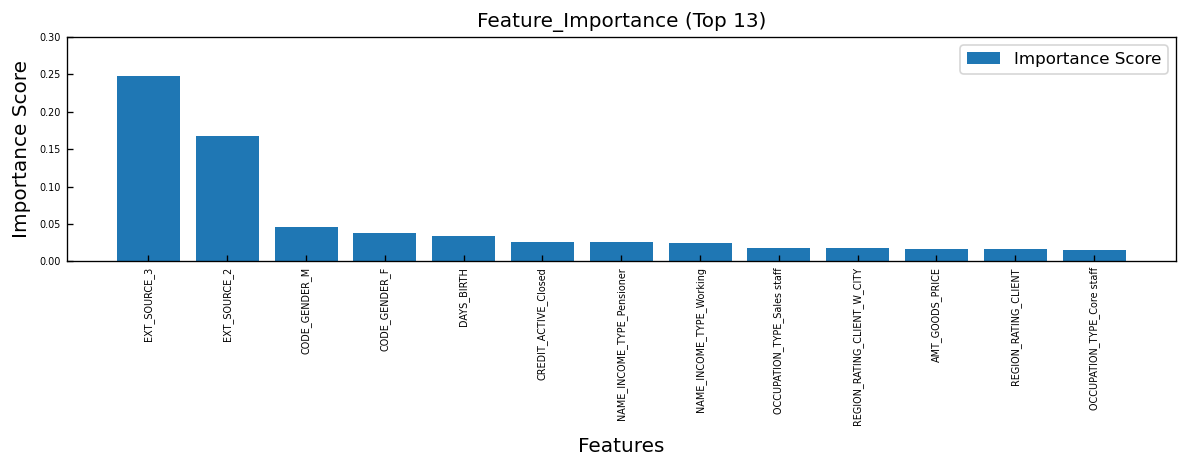

In [8]:
fig, ax = plt.subplots(figsize = (10, 4), dpi = 120, facecolor = 'white')

ax.bar(feature_importance_df['features'][:15].drop([44, 31]), feature_importance_df['feature_importance'][:15].drop([44, 31]), label = 'Importance Score')
ax.tick_params(axis = 'x', direction = 'in', rotation = 90, labelsize = 'xx-small')
ax.tick_params(axis = 'y', direction = 'in', labelsize = 'xx-small')
ax.set_ylim(0, 0.3)
ax.set_title('Feature_Importance (Top 13)')
ax.set_ylabel('Importance Score', size = 'large', labelpad = 5)
ax.set_xlabel('Features', size = 'large', labelpad = 7)
ax.legend(fontsize = 'medium')

fig.tight_layout()